This notebook takes your original photos and your shapefile of caravans and cuts 224 * 224 * 3 small patches centred over caravans out of your original images. It then also creates 224 * 224 * 1 masks, which get labelled in the label_masks.ipynb. The functions written here gives an option to georeference images and masks. It assumes you have an initial CSV with detailed information about all of your caravan polygons, their geometry, and the image they relate to, and that your images are already georeferenced.

In [2]:
import rasterio as rst
import rasterio.mask as mask
import matplotlib.pyplot as plt
import matplotlib as mpl 
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, box
from copy import deepcopy
import shapely
import pandas as pd
from shapely.wkt import loads
import os

In [5]:
#read in caravan csv (which has bounding boxes and matching tile names)
caravans=pd.read_csv(ROOT_DIR+".../caravanProject/maia_caravans_within.csv", delimiter=',')
#turn the csv into a geodataframe
caravans = gpd.GeoDataFrame(caravans,
                             crs = {'init': 'epsg:27700'},
                             geometry = caravans['geometry'].apply(lambda geom: loads(geom)))

#create a list of all the tile_names of the images that correspond to maia topo caravan polygons - useful later on
tile_names=[]
directory = ".../caravanProject/imagery/images_maia_topo_polygons"
for i in os.listdir(directory):
    if i.endswith(".jpg"):
        tile_names.append(i[:-4])


In [12]:
caravans.head()

Unnamed: 0                                     FID  \
0           0  {A699B798-5168-0682-E040-A40A262C4E4A}   
1           1  {A699B798-5389-0682-E040-A40A262C4E4A}   
2           2  {A699B798-53BC-0682-E040-A40A262C4E4A}   
3           3  {A699B798-51AF-0682-E040-A40A262C4E4A}   
4           4  {A699B798-51D8-0682-E040-A40A262C4E4A}   

                       FORM_DESC  FORMV  FUNC_DESC  FUNCTIONV  \
0  Static Caravan Or Mobile Home   3850        NaN       1002   
1  Static Caravan Or Mobile Home   3850        NaN       1002   
2  Static Caravan Or Mobile Home   3850        NaN       1002   
3  Static Caravan Or Mobile Home   3850        NaN       1002   
4  Static Caravan Or Mobile Home   3850        NaN       1002   

                                            geometry       cminx       cminy  \
0  POLYGON Z ((259472.92 279785.36 63.8, 259463.3...  259463.360  279785.360   
1  POLYGON Z ((259526.13 279812.91 57.718, 259525...  259513.380  279808.970   
2  POLYGON Z ((259476.74 279766.82 65.20700000000...  259464.052  279763.746   
3  POLYGON Z ((259441.62 279793.78 63.111, 259440...  259429.890  279788.124   
4  POLYGON Z ((259463.31 279808.78 62.57, 259472....  259461.440  279800.070   

       cmaxx  ...                                               geom  \
0  259475.26  ...  0106000020346C00000100000001030000000100000005...   
1  259526.25  ...  0106000020346C00000100000001030000000100000005...   
2  259476.74  ...  0106000020346C00000100000001030000000100000005...   
3  259441.62  ...  0106000020346C00000100000001030000000100000005...   
4  259472.65  ...  0106000020346C00000100000001030000000100000005...   

         min_x        min_y        max_x        max_y  \
0  258999.9981  278999.9963  260000.0003  280000.0001   
1  258999.9981  278999.9963  260000.0003  280000.0001   
2  258999.9981  278999.9963  260000.0003  280000.0001   
3  258999.9981  278999.9963  260000.0003  280000.0001   
4  258999.9981  278999.9963  260000.0003  280000.0001   

                                                bbox  x_min  y_min  x_max  \
0  258999.998086107,278999.996337028,260000.00032...   1853   3141   1901   
1  258999.998086107,278999.996337028,260000.00032...   2053   3235   2105   
2  258999.998086107,278999.996337028,260000.00032...   1856   3054   1906   
3  258999.998086107,278999.996337028,260000.00032...   1719   3152   1766   
4  258999.998086107,278999.996337028,260000.00032...   1845   3200   1890   

   y_max  
0   3179  
1   3262  
2   3095  
3   3197  
4   3235  

[5 rows x 25 columns]

In [4]:
tile_names[:5]

['NH6148', 'NN9613', 'NO2423', 'NS1984', 'SH4393']

In [5]:
# try the process with a single tile

#read tile
filestring = ".../caravanProject/imagery/images_maia_topo_polygons/geo_tiffs/NN9613.jpg"

with rst.open(filestring) as raster:
    # get xmin and ymin of image tile
    tile_xmin, tile_ymax, cellsize = (raster.bounds.left, raster.bounds.top, raster.res[0])
    # read the raster file
    image = raster.read()
    # move axis - switches the channels so the depth is the last channel. this puts the image in the right shape to get a mask
    image = np.moveaxis(image, 0, -1)
    # make a raster mask - the index here means you are just doing it on one channel
    caravan_mask = mask.raster_geometry_mask(raster, caravans['geometry'], invert=True, pad=True)[0] 

In [6]:
image.shape

(4000, 4000, 3)

(2000, 750)

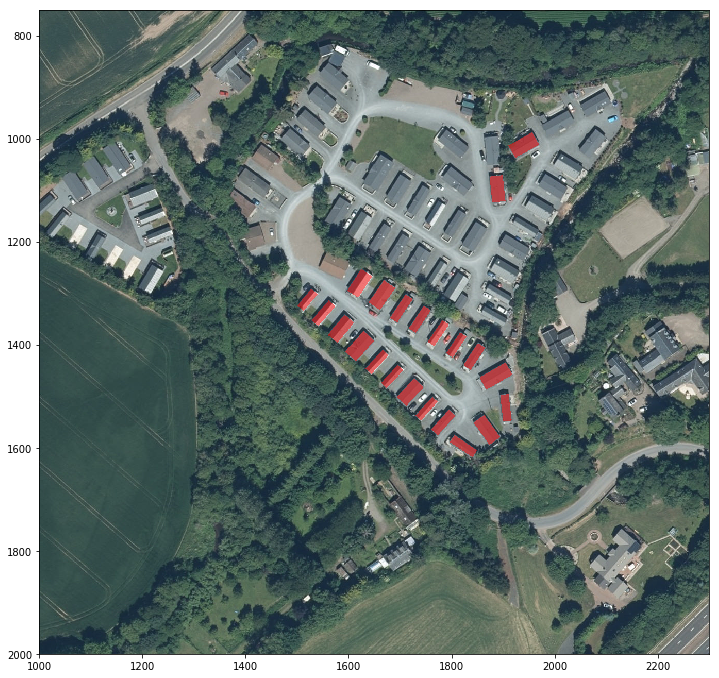

In [7]:
#plot your tile and caravans that you have for that tile - output shows we don't have polygons for all caravans in the image tile
f, ax = plt.subplots(figsize = (12,12))

# plot image
ax.imshow(image)

# make and plot mask of caravans in red
ax.imshow(caravan_mask, alpha = 0.5, cmap = mpl.colors.ListedColormap(['None','r']))

# zoom to area that holds caravan masks. if you put small value first in y axis. it will flip it on the y axis.
ax.set_xlim([1000,2300])
ax.set_ylim([2000,750])

In [8]:
#function to plot centroids of caravans in image coords - this becomes the centre of the new image patches 
def getImageCoords(geom, xmin, ymax, cellsize):
    c_x, c_y=np.array(geom.centroid)
    img_x=(c_x-xmin)/cellsize
    img_y=(ymax-c_y)/cellsize
    return Point(img_x,img_y)

In [9]:
#add a column 'centroids' to the caravan df 
centroids=caravans['geometry'].apply(lambda x: getImageCoords(x, tile_xmin, tile_ymax, cellsize))
centroids.head()

0     POINT (-146121.977848394 1736838.952667174)
1     POINT (-145920.773054959 1736750.620157216)
2     POINT (-146118.7216586657 1736925.68408508)
3    POINT (-146258.2226950651 1736824.316285366)
4               POINT (-146131.8136 1736782.2956)
Name: geometry, dtype: object

(2000, 750)

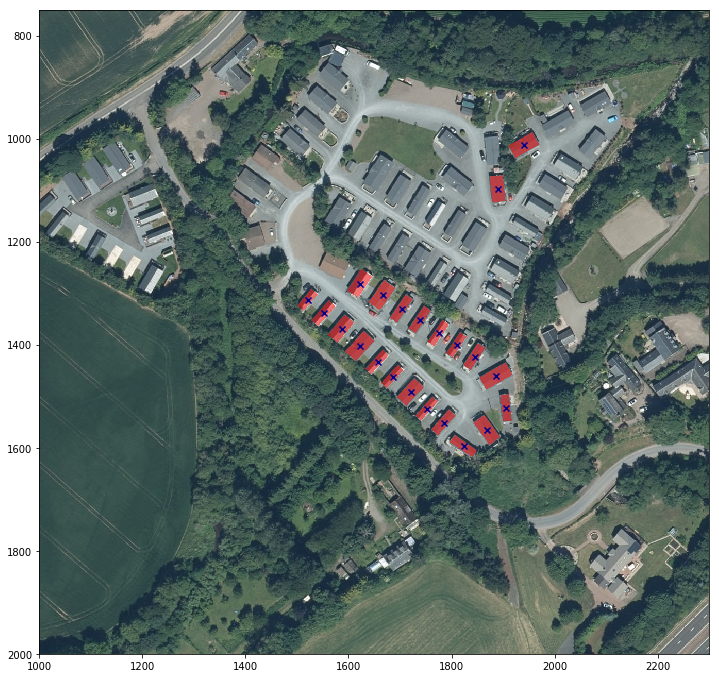

In [10]:
f, ax = plt.subplots(figsize = (12,12))

# plot image
ax.imshow(image)
# make and plot mask of caravans in red.
ax.imshow(caravan_mask, alpha = 0.5, cmap = mpl.colors.ListedColormap(['None','r']))

# plot centroids
centroids.plot(color = 'darkblue', marker = 'x', ax=ax)

# zoom to area that holds caravan masks
ax.set_xlim([1000,2300])
ax.set_ylim([2000,750])

In [11]:
#create boxes around caravans with the caravan centre as the centre of the images
def getImageBox(geom, xmin, ymax, cellsize):
    c_x, c_y = np.array(geom.centroid)
    img_x = ((c_x - xmin)//cellsize) - 112
    img_y = ((ymax - c_y)//cellsize) - 112
    return box(img_x, img_y, img_x + 224, img_y +224)

In [12]:
# create a variable with the boxes around the caravan centroids
boxes = caravans['geometry'].apply(lambda x: getImageBox(x, tile_xmin, tile_ymax, cellsize))

(1800, 800)

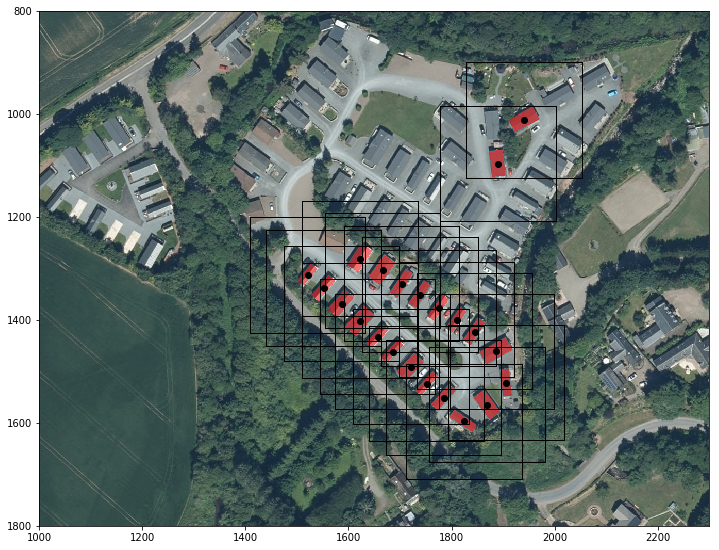

In [13]:
f, ax = plt.subplots(figsize = (12,12))
# plot image
ax.imshow(image)
# make and plot mask of caravans in red.

ax.imshow(caravan_mask, alpha = 0.5, cmap = mpl.colors.ListedColormap(['None','r']))

# plot example centroid and box 
centroids[10731:10755].plot(color = 'k', ax=ax)
boxes[10731:10755].plot(facecolor = 'none', edgecolor = 'k', ax=ax)

# zoom to area that holds caravan masks
ax.set_xlim([1000,2300])
ax.set_ylim([1800,800])

In [14]:
#function to georeference the subsetted image. It gets used in the subset image function below, so that it is 
#possible to output a georeferenced subset.
#xmin and ymin are the extents of your boxes in real space 
#trans is the transform parameters of the raster tile. trans[0] and trans[3] are the xmin and ymin of the image time
#These first get changed to fit image coords of the new subset and then an affine transformation is used to georeference subset
def georeferenceBox(tile, xmin, ymin):
    trans = deepcopy(tile.get_transform())
    trans[0] = trans[0] + (xmin * trans[1])
    trans[3] = trans[3] +((ymin) * trans[5])
    return rst.Affine.from_gdal(*trans)

In [15]:
#function to subset the image, i.e. actually cut the image to smaller 224*224 patches surrounding the caravan.
#option to georeference the image or keep in the image space.
def subSetImage(image, boxes, georef = False, tile = None):
    #xmin, ymin, xmax, ymax = map(int, boxes.bounds.values[0])
    xmin, ymin, xmax, ymax = map(int, boxes.bounds)
    if georef:
        if not tile:
            print("Please supply the original image tile")
        else:
            new_transform = georeferenceBox(tile, xmin, ymin)
            return image[ymin:ymax,xmin:xmax,:], new_transform
    else:
        return image[ymin:ymax,xmin:xmax,:]

In [25]:
#subset a sample of 9 in the image above - which are found in the 
subsets = []
for b in boxes[10731:10740].sample(9):
    subsets.append(subSetImage(image, b))
print(subsets)

[array([[[ 79,  98,  94],
        [ 46,  67,  65],
        [ 37,  58,  57],
        ...,
        [149, 159, 160],
        [146, 157, 156],
        [142, 152, 150]],

       [[ 67,  87,  82],
        [ 39,  59,  55],
        [ 31,  51,  47],
        ...,
        [151, 161, 162],
        [148, 158, 157],
        [143, 154, 152]],

       [[ 58,  79,  71],
        [ 49,  68,  63],
        [ 43,  64,  59],
        ...,
        [155, 165, 166],
        [151, 161, 161],
        [146, 157, 155]],

       ...,

       [[145, 156, 127],
        [147, 159, 127],
        [124, 138, 106],
        ...,
        [154, 169, 167],
        [155, 169, 167],
        [152, 166, 165]],

       [[115, 125,  96],
        [125, 137, 103],
        [117, 130,  98],
        ...,
        [148, 165, 163],
        [149, 164, 163],
        [146, 160, 160]],

       [[ 95, 110,  79],
        [ 92, 109,  80],
        [ 92, 109,  80],
        ...,
        [151, 163, 162],
        [147, 160, 159],
        [142, 155, 154]

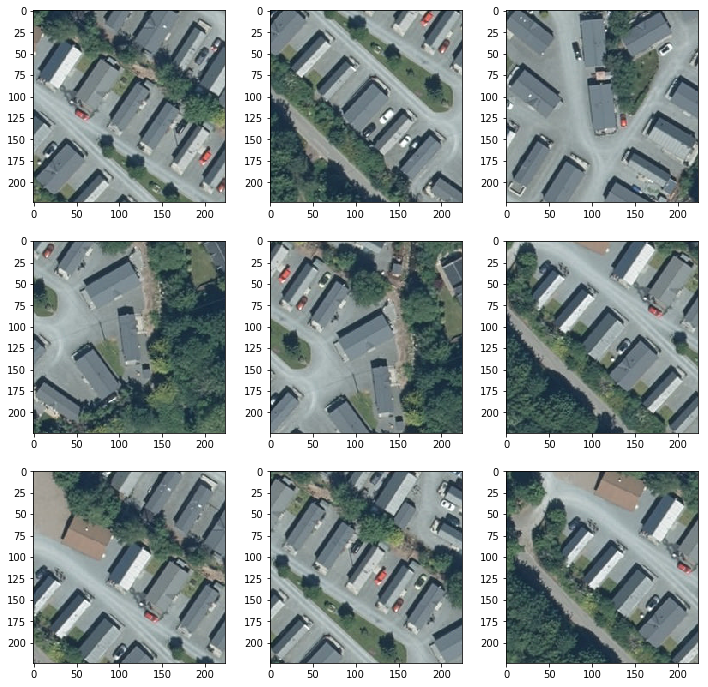

In [26]:
f, axes = plt.subplots(3,3,figsize = (12,12))
# plot subset images
i = 0
for row in axes:
    for ax in row:
        ax.imshow(subsets[i])
        i+=1

In [37]:
# save the subset image as a georeferenced tif.
sub, trans = subSetImage(image, boxes[10731], True, raster)
save = ".../caravanProject/imagery/images_maia_topo_polygons/training_patches/sub_test.tif"
    
with rst.open(save, 'w', driver= 'GTiff', compress = 'lzw',
                width = sub.shape[0], height = sub.shape[1], count = sub.shape[2],
                transform = trans, dtype= 'uint8' ) as out:
    out.write(np.moveaxis(sub,-1,0))

In [38]:
# create image subset masks. masks are needed for maskrcnn. first open to subset and then mask it
with rst.open(save,'r') as subset:
    caravan_mask = mask.raster_geometry_mask(subset, caravans['geometry'], invert=True, pad = True)[0].astype(int)

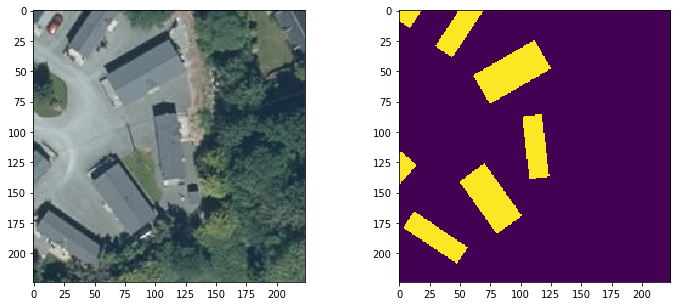

In [39]:
#plot the subset and mask for a check it worked 
f, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

ax1.imshow(sub)
ax2.imshow(caravan_mask)

In [40]:
#function to get a bounding box around the caravans in the image space. This is used in the get BBs function below
#the input xmin, ymax are from the image tile, the geom is the geom of the caravan
def getImageBox2(geom, xmin, ymax, cellsize):
    new_xmin = (geom.bounds[0] - xmin) // cellsize
    new_ymin = (ymax - geom.bounds[1]) // cellsize
    new_xmax = (geom.bounds[2] - xmin) // cellsize
    new_ymax = (ymax - geom.bounds[3]) // cellsize
    return box(new_xmin, new_ymin, new_xmax, new_ymax)
#get the bounding box (envelope) for a geom (caravan geom). this function helps
#specifies that the geometry needs to be within the tile to then apply the getImageBox2 function 
#(i.e. get the new box around the caravan)
def getBBs(geom, tile_string):
    envelopes = geom.envelope
    with rst.open(tile_string,'r') as tile:
        xmin = tile.bounds.left
        xmax = tile.bounds.right
        ymin = tile.bounds.bottom
        ymax = tile.bounds.top
        cellsize = tile.res[0]
        tile_box = box(xmin, ymin, xmax, ymax)
    
    envelopes = envelopes[envelopes.within(tile_box)]
    #envelopes = envelopes[envelopes.intersects(tile_box)]
    
    return envelopes.apply(lambda x: getImageBox2(x, xmin, ymax,cellsize))

In [41]:
# get bounding boxes for subsets
bbs = getBBs(caravans,save)

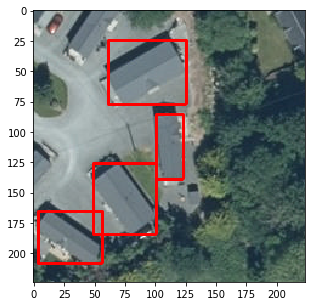

In [42]:
#plot for a check
f, ax = plt.subplots(figsize = (5,5))

ax.imshow(sub)
bbs.plot(facecolor = 'none', edgecolor = 'r', lw = 3, ax=ax)

In [43]:
bbs.apply(lambda x: x.bounds).values

array([(101.0, 85.0, 123.0, 139.0), (61.0, 24.0, 125.0, 77.0),
       (49.0, 126.0, 101.0, 184.0), (3.0, 165.0, 56.0, 208.0)],
      dtype=object)

In [44]:
#function to get (224*224) box around centroid of geom(=caravan) in real world coordinates
def getRealBox(geom, cellsize):
    c_x, c_y = np.array(geom.centroid)
    return box(c_x - (112*cellsize), c_y- (112*cellsize), c_x + (112*cellsize), c_y + (112*cellsize))

In [21]:
#finally cut image square patches for a sample of 1000 caravans in your dataset and create masks for the 1000.
#if caravans fall too close to an edge, i.e. under 112 pixels then it will be skipped
for idx, caravan in caravans.sample(1000).iterrows():
    
    # get the relevant image tile
    filestring = caravan['geotiff']
    with rst.open(filestring, 'r') as raster:
        xmin = raster.bounds.left
        xmax = raster.bounds.right
        ymin = raster.bounds.bottom
        ymax = raster.bounds.top
        cellsize = raster.res[0]
        tile_box = box(xmin, ymin, xmax, ymax)
        image = raster.read()
        image = np.moveaxis(image, 0, -1) #switches the channels so the depth is the last channel. this puts the image in the right shape to get a mask
        
        real_box = getRealBox(caravan['geometry'], cellsize) #checks if coordinates of the box is within the tile box coords
        if real_box.within(tile_box):
            image_box = getImageBox(caravan['geometry'], xmin, ymax, cellsize) #gets the box around caravan in image coords
            sub, sub_trans = subSetImage(image, image_box, True, raster) #subset the image using the image_box bounds, georeference paramater set to true
            save = f'/caravanProject/imagery/images_maia_topo_polygons/training_patches/Subsets/{idx}.tif'
    
            with rst.open(save, 'w', driver= 'GTiff', compress = 'lzw',
                          width = sub.shape[0], height = sub.shape[1], count = sub.shape[2],
                          transform = sub_trans, dtype= 'uint8' ) as out:
                out.write(np.moveaxis(sub,-1,0))
                
            with rst.open(save,'r') as subset:
                caravan_mask, caravan_trans, window = mask.raster_geometry_mask(subset, 
                                                                                caravans['geometry'], 
                                                                                invert=True, 
                                                                                pad = True)
                #caravan_mask = caravan_mask * 255
                save_mask = f'.../caravanProject/imagery/images_maia_topo_polygons/training_patches/Masks/{idx}.tif'
                with rst.open(save_mask, 'w', driver= 'GTiff', compress = 'lzw',
                          width = caravan_mask.shape[0], height = caravan_mask.shape[1], count = 1,
                          transform = caravan_trans, dtype= rst.uint8) as out:
                    out.write(caravan_mask.astype('uint8'),1)
            
        else:
            continue